In [1]:
import io, time, json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
from tensorflow.keras.utils import to_categorical
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# Grabbing the nominees
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        result: dict, movie name as key, movie information as value
    """
    # remember to use browser header here, or cannot retrieve full data from the website
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    response = requests.get(url, headers = headers)
    html = response.content
    soup = BeautifulSoup(html,'lxml')

    result = {}
    for item in soup.find_all('div', {'class':'result-subgroup subgroup-awardcategory-chron'}):
        try:
            award_title = item.find('div',{'class':'result-subgroup-title'}).find('a',{'class':'nominations-link'}).contents[0]
            if award_title == 'BEST PICTURE':
                sub_groups = item.find_all('div',{'class':'result-details awards-result-actingorsimilar'})
                for sub in sub_groups:
                    sub_result = {}
                    film_title = sub.find('div',{'class':'awards-result-film-title'}).find('a',{'class':'nominations-link'}).contents[0]
                    is_winner = 1
                    statement = sub.find('div',{'class':'awards-result-nominationstatement'}).find('a',{'class':'nominations-link'}).contents[0]           
                    sub_result['film_title'] = film_title
                    sub_result['is_winner'] = is_winner
                    sub_result['statement'] = statement
                    result[film_title] = sub_result
        except Exception:
            pass
    return result

In [3]:
# data of year 2016
best_2016 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:89,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2017
best_2017 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:90,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2018
best_2018 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:91,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

In [4]:
#best_2017

In [5]:
# Load Data
import numpy as np
import pandas as pd
# read from award
df_awards = pd.read_csv('database.csv', skiprows = 1, names=['year','ceremony','award','winner','movieName','filmInfo'])
df_movies = pd.read_csv('movies.csv')
df_credits = pd.read_csv('credits.csv')

In [6]:
#View data
#df_awards #ends at 2015
#print("")
#print(df_credits.head())

In [7]:
# append the data we scrapped to the df_awards
data = []
for k,v in best_2016.items():
    row = []
    row.append(['2016', 89, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])
  
for k,v in best_2017.items():
    row = []
    row.append(['2017', 90, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data.append(row[0])

#for k,v in best_2018.items():
#    row = []
#    row.append(['2018', 91, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
#    data.append(row[0])

#data #Looks good

In [8]:
# pass the column name to the columns!!! Or there will be a runtime error
df_awards=df_awards.append(pd.DataFrame(data,columns=['year','ceremony','award','winner','movieName','filmInfo']),ignore_index=True)

#df_awards 
#9982 rows × 6 columns, no duplicate entries

In [9]:
# Data Manipulation - Joining the dataframes
# We start by saving only the movies we have credits info for and merge on the same movie id

if 'title' in df_credits.columns: 
  df_credits = df_credits.drop('title',axis=1) 
df_credits_movies = df_credits.set_index('movie_id').join(df_movies.set_index('id'))
#df_credits_movies
# 9982 rows --> 4803 rows x 21 columns

In [10]:
#df_credits_movies.dtypes

# Reset the data types and get the earliest date of release_date
df_credits_movies['release_date'] = pd.to_datetime(df_credits_movies['release_date'])
#get the earliest release date from the dataset
min_year = min(df_credits_movies['release_date']) #1916-09-04
max_year = max(df_credits_movies['release_date']) #2017-02-03

In [11]:
# Select movies that are only in Outstanding Picture or Best Picture awards category and create a new df, df_picture_awards
df_picture_awards = df_awards.loc[df_awards['award'].isin(['Outstanding Picture','Best Picture'])]
df_picture_awards.reset_index(drop = True, inplace = True)
#332 Rows

# Get only movies that hae been released
df_credits_movies = df_credits_movies.loc[df_credits_movies['status'].isin(['Released'])]

#print("--------------")
#print(df_picture_awards.columns)
#print("--------------")
#print(df_credits_movies.columns)

In [12]:
# Replace all the null value in ‘winner’ column with 1
# df_picture_awards['winner'].isnull().sum()
df_picture_awards['winner'].fillna(1,inplace = True)


In [13]:
# join df_credits_movies and df_picture_awards by movie name

# Change the title in the movie to lower case
import re
movieName = [re.sub(r'[^\w\s]','',x) for x in df_picture_awards['movieName'].str.lower().str.strip().values]
title = [re.sub(r'[^\w\s]','',x) for x in df_credits_movies['title'].str.lower().str.strip().values]

df_picture_awards.loc[:,'movie_title'] = movieName 
df_credits_movies.loc[:,'movie_title'] = title

# check the dataframe, we can see the string in movie_title now is valid
#df_picture_awards.movie_title

In [14]:
# join the two tables, merge the data
df = df_picture_awards.merge(df_credits_movies, left_on='movie_title', right_on='movie_title', how='right')
df = df.reset_index(drop=True)

# @Priya - PROBLEM HERE? WE'RE GETTING JUNK DATA AT THE END OF OUR MASTERLIST.CSV, PRETTY SURE IT'S FOR RECENT YEAR'S DATA
# Maybe single out the junk data 1st and see if we can clean it up? If you sort the csv by release date you can find the junk.

#drop the columns from award table
df.drop('homepage',axis = 1, inplace = True)
df.drop('year',axis = 1, inplace = True)
df.drop('award',axis = 1, inplace = True)
df.drop('movieName',axis = 1, inplace = True)
df.drop('filmInfo',axis = 1, inplace = True)
df.drop('ceremony',axis = 1, inplace = True)
df['winner'].fillna(0,inplace=True) #fill NA with 0

# Print master df to csv
# 4795 rows of movies with appended Best Picture data, that we had crew info for
df.to_csv('masterList.csv', index=False)

#df

In [15]:
#df['cast'].dtype

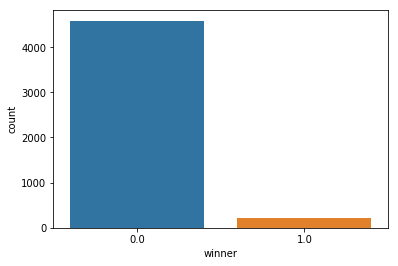

In [16]:
# We will choose the under-sampling by sampling from the 0-labeled data. 
# We need to first get a subset of nominated data, then sample from the non-nominated data, 
# and finally append the sampled data to the subset of nominated data.
sns.countplot(x='winner', data = df)


In [17]:
#Get the number of 0 labeled data, and the number of 1 labeled data
print(len(df.loc[df['winner'] == 0])) #4586
print(len(df.loc[df['winner'] == 1])) #209

4586
209


In [18]:
#balance the data
df_subset_0 = df.loc[df['winner'] == 0]
df_subset_1 = df.loc[df['winner'] == 1]

df_subset_0.drop('winner',axis=1,inplace=True)
df_subset_1.drop('winner',axis=1,inplace=True)

#sample with replacement
df_subset_0 = df_subset_0.sample(400) 
df_subset = pd.concat([df_subset_0,df_subset_1],ignore_index = True)
df_new = df_subset.merge(df_picture_awards, left_on = 'movie_title', right_on = 'movie_title', how = 'left')
df_new = df_new.fillna(0)

In [19]:
print(len(df_new))

609


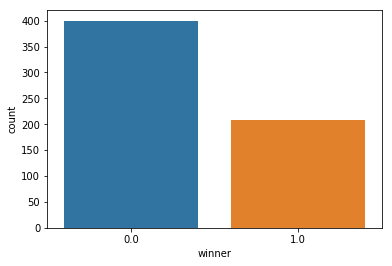

In [20]:
sns.countplot(x='winner', data = df_new)

In [21]:
#check number of null values in the dataset
df_new.isnull().sum()

movie_title             0
cast                    0
crew                    0
budget                  0
genres                  0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
year                    0
ceremony                0
award                   0
winner                  0
movieName               0
filmInfo                0
dtype: int64

In [22]:
#Exploratory Data Analysis

# check the data types and select numeric variables
df_new.dtypes

movie_title                     object
cast                            object
crew                            object
budget                           int64
genres                          object
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                          object
tagline                         object
title                           object
vote_average                   float64
vote_count                       int64
year                             int64
ceremony                       float64
award                           object
winner                         float64
movieName                

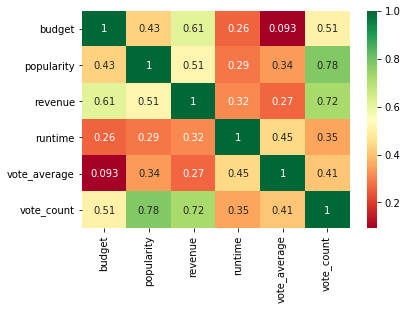

In [23]:
# correlation analysis
g = sns.heatmap(df_new[['budget','popularity','revenue','runtime','vote_average','vote_count']].corr(),cmap='RdYlGn',annot=True)

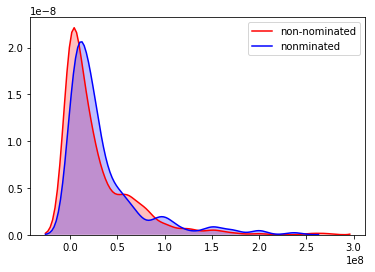

In [24]:
# Density Curve
# budget
budget0 = df_new[df_new['winner'] == 0]['budget']
budget1 = df_new[df_new['winner'] == 1]['budget']

g = sns.kdeplot(budget0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(budget1, legend = True, shade=True, color='b', label = 'nonminated')

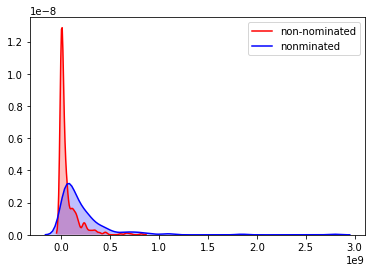

In [25]:
# revenue
# density curve
revenue0 = df_new[df_new['winner'] == 0]['revenue']
revenue1 = df_new[df_new['winner'] == 1]['revenue']

g = sns.kdeplot(revenue0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(revenue1, legend = True, shade=True, color='b', label = 'nonminated')

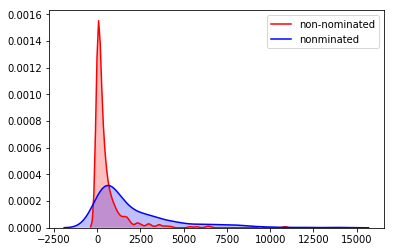

In [26]:
# vote count
vc0 = df_new[df_new['winner'] == 0]['vote_count']
vc1 = df_new[df_new['winner'] == 1]['vote_count']

g = sns.kdeplot(vc0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(vc1, legend = True, shade=True, color='b', label = 'nonminated')

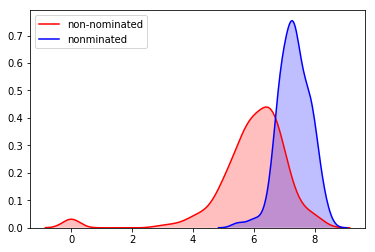

In [27]:
# vote average
va0 = df_new[df_new['winner'] == 0]['vote_average']
va1 = df_new[df_new['winner'] == 1]['vote_average']

g = sns.kdeplot(va0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(va1, legend = True, shade=True, color='b', label = 'nonminated')

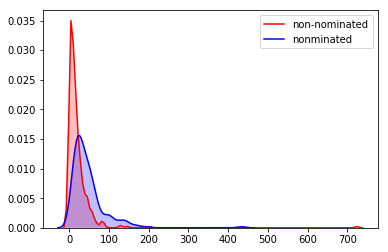

In [28]:
# popularity
popularity0 = df_new[df_new['winner'] == 0]['popularity']
popularity1 = df_new[df_new['winner'] == 1]['popularity']

g = sns.kdeplot(popularity0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(popularity1, legend = True, shade=True, color='b', label = 'nonminated')

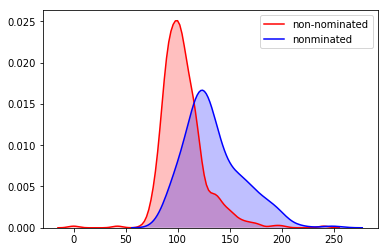

In [29]:
#runtime
runtime0 = df_new[df_new['winner'] == 0]['runtime']
runtime1 = df_new[df_new['winner'] == 1]['runtime']

g = sns.kdeplot(runtime0, legend = True, shade=True, color='r', label = 'non-nominated')
g = sns.kdeplot(runtime1, legend = True, shade=True, color='b', label = 'nonminated')

In [30]:
#genres
#clean the data
genres_name0 = {}
genres_name1 = {}
genres_set = set()
for i in range(len(df_new)):
    genres = json.loads(df_new.loc[i,'genres'])
    for it in genres:
        genres_set.add(it['name'])
        if df_new.loc[i,'winner'] == 0:
            if it['name'] not in genres_name0:
                genres_name0[it['name']] = 1
            else:
                genres_name0[it['name']] += 1
        if df_new.loc[i,'winner'] == 1:
            if it['name'] not in genres_name1:
                genres_name1[it['name']] = 1
            else:
                genres_name1[it['name']] += 1

genres_array0=[]
genres_array1=[]
for g in genres_set:
    if g in genres_name0:
        genres_array0.append(genres_name0[g])
    else:
        genres_array0.append(0)
    if g in genres_name1:
        genres_array1.append(genres_name1[g])
    else:
        genres_array1.append(0)


        
genres_all = []
genres_all.append(np.array(genres_array0)/sum(genres_array0))
genres_all.append(np.array(genres_array1)/sum(genres_array1))

In [31]:
df_genres = pd.DataFrame(genres_all, columns=list(genres_set))
print(df_genres.head())

      Crime  Foreign       War  Thriller    Horror     Drama    Comedy  \
0  0.052525  0.00303  0.013131  0.098990  0.044444  0.190909  0.157576   
1  0.054326  0.00000  0.044266  0.078471  0.004024  0.364185  0.064386   

   Animation   Mystery   Fantasy    Action   History   Romance   Western  \
0   0.023232  0.030303  0.020202  0.089899  0.010101  0.072727  0.007071   
1   0.004024  0.020121  0.028169  0.044266  0.072435  0.096579  0.012072   

     Family  Documentary  Science Fiction  Adventure     Music  
0  0.044444     0.008081         0.051515   0.055556  0.026263  
1  0.020121     0.000000         0.018109   0.054326  0.020121  


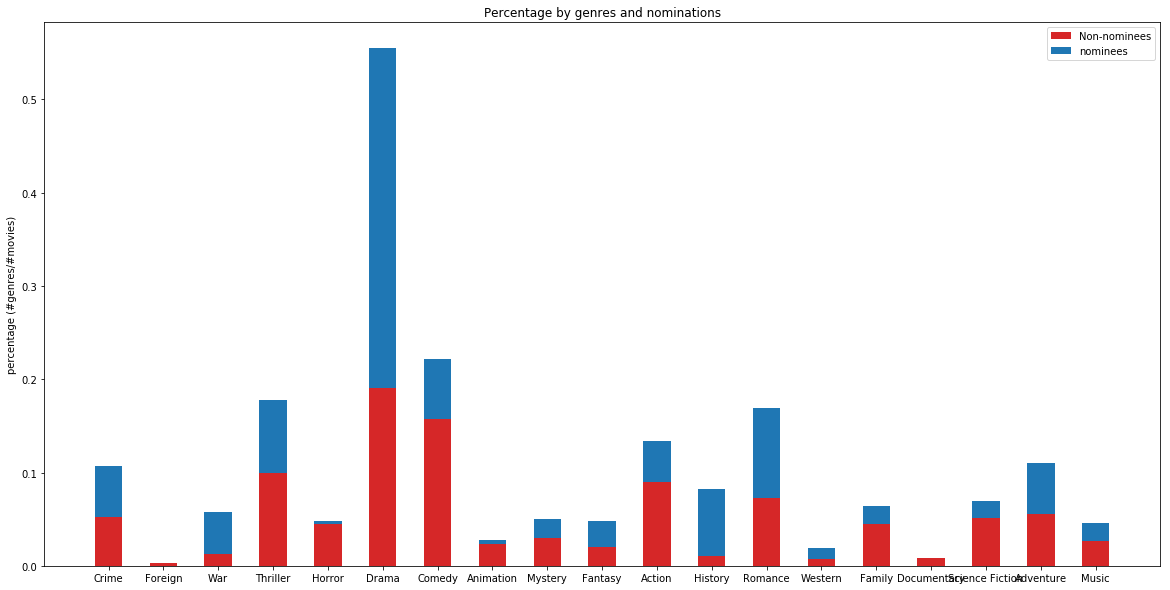

In [32]:
# draw stacked bar chart
N = len(df_genres.columns)
ind = np.arange(N)
width = 0.5

plt.figure(figsize=(20,10))
p1 = plt.bar(ind, df_genres.loc[[0]].values[0], width, color='#d62728')
p2 = plt.bar(ind, df_genres.loc[[1]].values[0], width, bottom=df_genres.loc[[0]].values[0])

plt.ylabel('percentage (#genres/#movies)')
plt.title('Percentage by genres and nominations')
plt.xticks(ind,df_genres.columns)
plt.legend((p1[0],p2[0]),('Non-nominees','nominees'))

In [33]:
# Feature Engineering
# Since many columns such as “crew”, “cast” contain information in json format, we need to extract useful information from the columns and then perform one hot encoding.
# We will transform our dataset into a all numeric matrix so that we can feed the data into our machine learning model.
# To look at the structure of column (eg.”cast”), we can use: df.loc[0,’cast’]
import json
def feature_engineering(column_name, df, json_name):
    """
    Args:
        column_name: the column name in the dataframe that contains a json file that needs to conduct feature engineering on
        df: dataframe that perform feature engineering on
        json_name: name in the json file that we want to extract
    
    Returns: new dataframe after feature engineering
    """
    
    name = {}

    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] not in name:
                name[it[json_name]] = 1
            else:
                name[it[json_name]] += 1
    
    final = {}
    index = 0
    for k,v in name.items():
        if v > 1:
            final[k] = index
            index += 1
    np_item = np.zeros((len(df),len(final)))
    item_dict = {}
    row = 0
    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] in final:
                index = final[it[json_name]]
                np_item[row][index] = 1
        row += 1

    df_item = pd.DataFrame(np_item, columns = list(final.keys()))
    df_output = pd.concat([df,df_item],axis = 1)
    
    return df_output

In [34]:
df2 = feature_engineering("cast", df_new, "name")
df2 = df2.drop('cast', axis = 1) #drop the column after feature engineering

In [35]:
# director
crew_name = {}

for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] not in crew_name:
                crew_name[it['name']] = 1
            else:
                crew_name[it['name']]+=1


# set the appear tims for actors
final_crew = {}
index = 0
for k,v in crew_name.items():
    if v > 0:
        final_crew[k] = index
        index += 1
# print(len(final_crew))

np_crew = np.zeros((len(df2), len(final_crew)))
row = 0
for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] in final_crew:
                index = final_crew[it['name']]
                np_crew[row][index] = 1
    row += 1

df_crew = pd.DataFrame(np_crew, columns = list(final_crew.keys()))
            
df3 = pd.concat([df2, df_crew], axis = 1)
# print(df.shape)

In [36]:
df3=df3.drop(['crew'],axis=1)
#genres
df4 = feature_engineering("genres", df3, "name")
df4 = df4.drop(['genres'], axis = 1)
#keywords
df5 = feature_engineering('keywords', df4, 'name')
df5 = df5.drop(['keywords'], axis = 1)
#production_companies
df6 = feature_engineering('production_companies',df5,'name')
df6 = df6.drop(['production_companies'],axis=1)
#production_countries
df7 = feature_engineering('production_countries',df6,'name')
df7 = df7.drop(['production_countries'],axis=1)
#spoken_languages
df8 = feature_engineering('spoken_languages',df7,'iso_639_1')
df8 = df8.drop(['spoken_languages'],axis=1)
# drop the columns not used
df_clean = df8.drop(["movie_title","original_title","overview","tagline",'title','original_language','status','release_date','movieName','filmInfo','award'],axis=1)

In [37]:
df_clean

,budget,popularity,revenue,runtime,vote_average,vote_count,year,ceremony,winner,Benedict Cumberbatch,...,gd,sh,cs,af,xh,zu,tr,vi,fa,ga
0,550000,0.480880,0,115.0,4.2,3,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,967686,20.544999,4270000,101.0,7.0,423,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20000000,13.906944,39143839,102.0,5.2,283,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8000000,8.717235,589304,106.0,6.7,21,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.607782,0,95.0,7.0,8,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.015295,0,90.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,62000000,18.096884,127666415,116.0,6.1,340,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,15000000,6.216203,30050028,114.0,6.3,252,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3000000,22.789649,177512032,91.0,5.7,722,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4000000,4.992475,41424067,120.0,6.5,91,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Model Training
# split
X = df_clean[df_clean.columns.difference(['winner'])]
# X = StandardScaler().fit_transform(X)
y = df_clean['winner']
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=1/7.0, random_state=0)

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
fit = pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# X_test = pca.transform(X_test)
# pca = PCA(n_components = 3)
# fit = pca.fit_transform(X)
# fit2 = pca.fit(X)
# print("Explained Variance: %s" % pca.explained_variance_ratio_) 
# print(fit)

In [41]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
# For small datasets, ‘liblinear’ is a good choice
logisticRegr = LogisticRegression(solver = 'liblinear')
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
# Predict for One Observation
predicted = logisticRegr.predict(X_test)
#print(logisticRegr.predict(X_test))
#print(y_test.index)
# df8['movie_title'][y_test.index]

In [43]:
logisticRegr.score(X_train, y_train)

1.0

In [44]:
logisticRegr.score(X_test, y_test) # 0.8850574712643678

0.896551724137931

In [45]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
sensitivity = tp/(tp+fn)
print(sensitivity) # 0.84375

0.875


In [46]:
# 3-fold Cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)
sumAccuracy = []
for train,test in skf.split(X,y):
#     logisticRegr.fit(df_clean.iloc[train][], )
    df_train = df_clean.iloc[train]
    df_test = df_clean.iloc[test]
    train_X = df_train[df_clean.columns.difference(['winner'])]
    train_y = df_train['winner']
    test_X = df_test[df_clean.columns.difference(['winner'])]
    test_y = df_test['winner']
    logisticRegr.fit(train_X, train_y)
    sumAccuracy.append(logisticRegr.score(test_X, test_y))
avg = np.mean(sumAccuracy)
print(avg) # 0.7751010491916065
#     print(df_clean.iloc[train,df_clean.columns.difference(['winner'])])

0.7208569831441348


In [47]:
# Test with 2018 Data
#best_2018

data2 = []
for k,v in best_2018.items():
    row = []
    row.append(['2018', 91, 'Best Picture', v['is_winner'], v['film_title'], v['statement']])
    data2.append(row[0]) 
data2

[['2018', 91, 'Best Picture', 1, 'Black Panther', 'Kevin Feige, Producer'],
 ['2018',
  91,
  'Best Picture',
  1,
  'BlacKkKlansman',
  'Sean McKittrick, Jason Blum, Raymond Mansfield, Jordan Peele and Spike Lee, Producers'],
 ['2018', 91, 'Best Picture', 1, 'Bohemian Rhapsody', 'Graham King, Producer'],
 ['2018',
  91,
  'Best Picture',
  1,
  'The Favourite',
  'Ceci Dempsey, Ed Guiney, Lee Magiday and Yorgos Lanthimos, Producers'],
 ['2018',
  91,
  'Best Picture',
  1,
  'Green Book',
  'Jim Burke, Charles B. Wessler, Brian Currie, Peter Farrelly and Nick Vallelonga, Producers'],
 ['2018',
  91,
  'Best Picture',
  1,
  'Roma',
  'Gabriela Rodríguez and Alfonso Cuarón, Producers'],
 ['2018',
  91,
  'Best Picture',
  1,
  'A Star Is Born',
  'Bill Gerber, Bradley Cooper and Lynette Howell Taylor, Producers'],
 ['2018',
  91,
  'Best Picture',
  1,
  'Vice',
  'Dede Gardner, Jeremy Kleiner, Adam McKay and Kevin Messick, Producers']]

In [48]:
# pass the column name to the columns!!! Or there will be a runtime error
df_2018=pd.DataFrame(data2,columns=['year','ceremony','award','winner','movieName','filmInfo'])

df_2018 
#9990 rows × 6 columns, no duplicate entries

,year,ceremony,award,winner,movieName,filmInfo
0,2018,91,Best Picture,1,Black Panther,"Kevin Feige, Producer"
1,2018,91,Best Picture,1,BlacKkKlansman,"Sean McKittrick, Jason Blum, Raymond Mansfield..."
2,2018,91,Best Picture,1,Bohemian Rhapsody,"Graham King, Producer"
3,2018,91,Best Picture,1,The Favourite,"Ceci Dempsey, Ed Guiney, Lee Magiday and Yorgo..."
4,2018,91,Best Picture,1,Green Book,"Jim Burke, Charles B. Wessler, Brian Currie, P..."
5,2018,91,Best Picture,1,Roma,"Gabriela Rodríguez and Alfonso Cuarón, Producers"
6,2018,91,Best Picture,1,A Star Is Born,"Bill Gerber, Bradley Cooper and Lynette Howell..."
7,2018,91,Best Picture,1,Vice,"Dede Gardner, Jeremy Kleiner, Adam McKay and K..."


In [49]:
import re
movieName = [re.sub(r'[^\w\s]','',x) for x in df_2018['movieName'].str.lower().str.strip().values]
title = [re.sub(r'[^\w\s]','',x) for x in df_credits_movies['title'].str.lower().str.strip().values]

df_2018.loc[:,'movie_title'] = movieName 
df_credits_movies.loc[:,'movie_title'] = title

df_test = df_2018.merge(df_credits_movies, left_on='movie_title', right_on='movie_title', how='left')

df_test = df_test.reset_index(drop=True)
df_test

,year,ceremony,award,winner,movieName,filmInfo,movie_title,cast,crew,budget,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,2018,91,Best Picture,1,Black Panther,"Kevin Feige, Producer",black panther,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,91,Best Picture,1,BlacKkKlansman,"Sean McKittrick, Jason Blum, Raymond Mansfield...",blackkklansman,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,91,Best Picture,1,Bohemian Rhapsody,"Graham King, Producer",bohemian rhapsody,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,91,Best Picture,1,The Favourite,"Ceci Dempsey, Ed Guiney, Lee Magiday and Yorgo...",the favourite,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,91,Best Picture,1,Green Book,"Jim Burke, Charles B. Wessler, Brian Currie, P...",green book,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,91,Best Picture,1,Roma,"Gabriela Rodríguez and Alfonso Cuarón, Producers",roma,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,91,Best Picture,1,A Star Is Born,"Bill Gerber, Bradley Cooper and Lynette Howell...",a star is born,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,91,Best Picture,1,Vice,"Dede Gardner, Jeremy Kleiner, Adam McKay and K...",vice,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_test.to_csv('bestPic2018Data.csv', index=False)


In [51]:


# @Priya - PROBLEM HERE? WE'RE GETTING JUNK DATA AT THE END OF OUR MASTERLIST.CSV, PRETTY SURE IT'S FOR RECENT YEAR'S DATA
# Maybe single out the junk data 1st and see if we can clean it up? If you sort the csv by release date you can find the junk.

#drop the columns from award table
df_test.drop('homepage',axis = 1, inplace = True)
df_test.drop('year',axis = 1, inplace = True)
df_test.drop('award',axis = 1, inplace = True)
df_test.drop('movieName',axis = 1, inplace = True)
df_test.drop('movie_title',axis = 1, inplace = True)
df_test.drop('filmInfo',axis = 1, inplace = True)
df_test.drop('ceremony',axis = 1, inplace = True)
df_test['winner'].fillna(0,inplace=True) #fill NA with 0

In [52]:
X_test = df_test.drop("winner", axis=1)
y_test = df_test["winner"]
print(X_test.shape, y_test.shape)

(8, 20) (8,)


In [53]:
X_test

,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
# For small datasets, ‘liblinear’ is a good choice

y_pred = logisticRegr.predict(X_test)

TypeError: float() argument must be a string or a number, not 'NaTType'

In [ ]:
print(f"Training Data Score: {logisticRegr.score(X_train, y_train)}")
print(f"Testing Data Score: {logisticRegr.score(X_test, y_test)}")

In [ ]:
predictions = logisticRegr.predict(X_test)

pd.DataFrame({"Prediction": predictions[:20], "Actual": y_test[:20]})

In [ ]:
print(len(predictions))